# Detectarea COVID-19 analizand opacitatea la nivelul plamanului utilizand radiografia plamanului

Image classification of Chest X Rays in one of three classes: Normal, Viral Pneumonia, COVID-19
Clasificarea imaginilor de tip radiografie se imparte in 3 clase: Normal, Pneumonie Virala, COVID-19

Craioveanu Sergiu-Ionut, 341A2

# Importam bibliotecile si dependintele necesare

In [1]:
%matplotlib inline

import os
import shutil
import random
import torch
import torchvision
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)

print('Versiune PyTorch: ', torch.__version__)

Versiune PyTorch:  1.5.1


# Pregatim seturile de antrenare si de testare

Celula de mai jos are ca scop crearea unor foldere de tip train/test, aferent fiecarei clase. In fiecare folder de test al unei clase aferente vor exista 30 de imagini care vor fi folosite pentru a oferi acuratetea predictiilor. 

3 clase * 30 imagini => 90 de imagini

In [2]:
class_names = ['normal', 'viral', 'covid']
root_dir = 'COVID-19 Radiography Database'
source_dirs = ['NORMAL', 'Viral Pneumonia', 'COVID-19']

if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.mkdir(os.path.join(root_dir, 'test'))

    for i, d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'test', c))

    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, 30)
        for image in selected_images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'test', c, image)
            shutil.move(source_path, target_path)

# Personalizarea metodei de prelucrare a bazei de date

In celula de mai jos am conceput metode ce vor facilita prelucrarea imaginilor intr-o maniera mai usoara. 
Numele fiecarei imagini va fi extrasa din ierarhia de fisiere, vor fi adaugate in liste si impartite/adresate in functie de nevoile ulterioare. 
Metodele de mai jos prezinta mai degraba un rol de verificare si usurinta in manevrarea datelor, decat o functionalitate esentiala.

In [3]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x.lower().endswith('png')]
            print(f'Am gasit {len(images)} exemple din clasa: {class_name}')
            return images
        
        self.images = {}
        self.class_names = ['normal', 'viral', 'covid']
        
        for c in self.class_names:
            self.images[c] = get_images(c)
            
        self.image_dirs = image_dirs
        self.transform = transform
        
        
    def __len__(self):
        return sum([len(self.images[c]) for c in self.class_names])
    
    
    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)

# Aplicarea transformarilor pe imagini, specifice ResNet

Aplicam transformarile de mai jos pentru a respecta cerintele imaginilor din retelele ResNet. Fiecare imagine pe care reteaua ResNet a fost antrenata, a fost supusa unor transformari de tipul celor de mai jos. Se poate observa totusi faptul ca imaginile de tip test sunt pastrate cu aceeasi orientare, pe cand in imaginile de antrenare introducem si metode de augmentare a datelor.

In [4]:
train_transform = torchvision.transforms.Compose([
    # Convertirea imaginilor la dimensiunea pe care modelul o asteapta
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(), # Convertirea la tenor
    # Normalizarea datelor la setarile pe care ResNet a fost antrenat
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225]) 
])


In [5]:
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
])


# Prepararea DataLoader

Mai jos vom chema clasa 'ChestXRayDataset', care va primi ca si parametri numele clasei/calea fisierelor si tipul transformarii. 
Acesta a fost motivul crearii acestei clase. Clasa de mai sus nu era absolut esentiala, dar ofera o intelegere mai buna asupra codului, impreuna cu o oarecare eleganta in apelare.

In [6]:
print(os.getcwd())
os.chdir('Dataset')
print(os.getcwd())

/home/serj/Desktop/VedereArtificiala
/home/serj/Desktop/VedereArtificiala/Dataset


In [7]:
train_dirs = {
    'normal': 'normal',
    'viral': 'viral',
    'covid': 'covid'
}

train_dataset = ChestXRayDataset(train_dirs, train_transform)

Am gasit 10162 exemple din clasa: normal
Am gasit 1315 exemple din clasa: viral
Am gasit 3586 exemple din clasa: covid


In [8]:
test_dirs = {
    'normal': 'test/normal',
    'viral': 'test/viral',
    'covid': 'test/covid'
}
test_dataset = ChestXRayDataset(test_dirs, test_transform)

Am gasit 30 exemple din clasa: normal
Am gasit 30 exemple din clasa: viral
Am gasit 30 exemple din clasa: covid


In [9]:
batch_size = 6

dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Check Number of batches
print('Numarul de batch-uri de antrenare:', len(dl_train))
print('Numarul de batch-uri de testare:', len(dl_test))

Numarul de batch-uri de antrenare: 2511
Numarul de batch-uri de testare: 15


# Vizualizarea imaginilor

Functia de mai jos a fost creata pentru a vizualiza imaginile. Din nou, aceasta functie de usureaza munca atunci cand vrem sa vizualizam anumite imagini dintr-un set de test/train cu un anumit label.

In [10]:
class_names = train_dataset.class_names

def show_images(images, labels, preds):
    plt.figure(figsize=(8, 4))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1, xticks=[], yticks=[])
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.455, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        
        col = 'green' if preds[i] == labels[i] else 'red'
        
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()

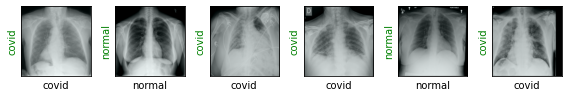

In [11]:
images, labels = next(iter(dl_train))
show_images(images, labels, labels)

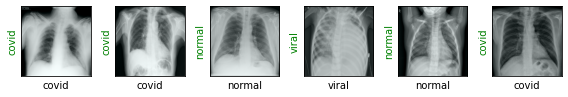

In [12]:
images, labels = next(iter(dl_test))
show_images(images, labels, labels)

# Crearea Modelului

Importam modelul ResNet18 din biblioteca PyTorch. De altfel, orice model ar fi putut fi importat, dar ResNet ne ofera cel mai bun compromis intre viteza/performante pentru problema de fata.

In [13]:
resnet18 = torchvision.models.resnet18(pretrained=True)
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
# Modificam ultimul strat al retelei pentru a contine 3 neuroni intr-o maniera densa,
# care sa ne permita predictia a 3 clase: covid, normal, viral
resnet18.fc = torch.nn.Linear(in_features=512, out_features=3)

# Alegem functia de pierdere. In cazul asta, CrossEntropyLoss se foloseste pentru clasificarea multipla.
loss_fn = torch.nn.CrossEntropyLoss()

# Alegem si mecanismul de optimizare. In cazul asta, optam pentru Adam din motive de popularitate.
optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5)

In [15]:
def show_preds():
    resnet18.eval()
    images, labels = next(iter(dl_test))
    outputs = resnet18(images)
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)

Mai jos ne asteptam ca predictiile pe care le facem pentru un batch de 6 imagini oarecare sa fie eronate, ceea ce se si poate vedea.

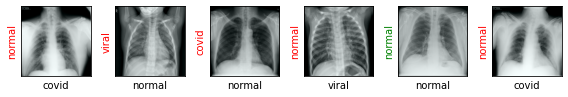

In [16]:
show_preds()

# Antrenarea Modelului

In [17]:
def train(epochs):
    print('Incepem antrenarea...')
    for e in range(0, epochs):
        print('=' * 20)
        print(f'Epocile de start {e+1}/{epochs}')
        print('=' * 20)
        
        train_loss = 0;
        # Punem modelul in modul de antrenare
        resnet18.train()
        
        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad()
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if train_step % 20 == 0: # Evaluam performantele la fiecare 20 de pasi
                print('Evaluarea la pasul', train_step)
                acc = 0.
                val_loss = 0.
                resnet18.eval() # Trecem modelul in modul de evaluare
                
                for val_step, (images, labels) in enumerate(dl_test):
                    outputs = resnet18(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()
                    
                    _, preds = torch.max(outputs, 1) 
                    acc += sum((preds == labels).numpy())
                val_loss /= (val_step + 1)
                acc = acc / len(test_dataset)
                print(f'Val loss (eroarea): {val_loss:.4f}, Acc (acuratete): {acc:.4f}')
                show_preds()
                # Dupa ce am terminat evaluarea, trecem iar modelul in modul de antrenare pentru urmatorul pas
                resnet18.train() 
                
                if acc > 0.95:
                    print('Conditia de performanta satisfacuta!')
                    return
                
        train_loss /= (train_step + 1)
        print(f'Eroarea pe setul de antrenare: {train_loss:.4f}')
        
                

Incepem antrenarea...
Epocile de start 1/1
Evaluarea la pasul 0
Val loss (eroarea): 1.0890, Acc (acuratete): 0.3778


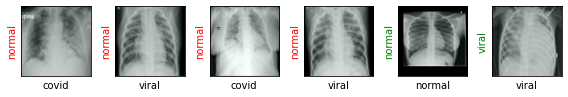

Evaluarea la pasul 20
Val loss (eroarea): 0.8287, Acc (acuratete): 0.6111


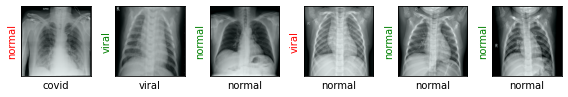

Evaluarea la pasul 40
Val loss (eroarea): 0.6339, Acc (acuratete): 0.7333


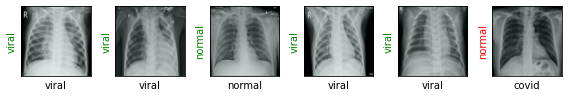

Evaluarea la pasul 60
Val loss (eroarea): 0.4472, Acc (acuratete): 0.7889


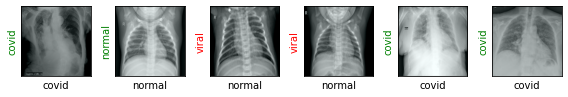

Evaluarea la pasul 80
Val loss (eroarea): 0.3209, Acc (acuratete): 0.9222


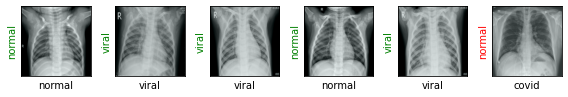

Evaluarea la pasul 100
Val loss (eroarea): 0.3324, Acc (acuratete): 0.8889


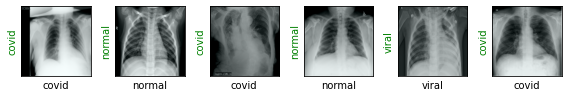

Evaluarea la pasul 120
Val loss (eroarea): 0.3531, Acc (acuratete): 0.8889


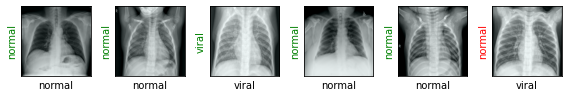

Evaluarea la pasul 140
Val loss (eroarea): 0.3000, Acc (acuratete): 0.9000


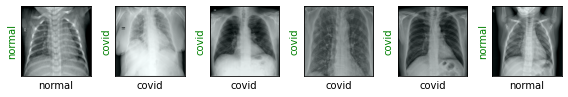

Evaluarea la pasul 160
Val loss (eroarea): 0.3484, Acc (acuratete): 0.9111


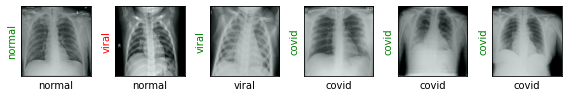

Evaluarea la pasul 180
Val loss (eroarea): 0.2264, Acc (acuratete): 0.9667


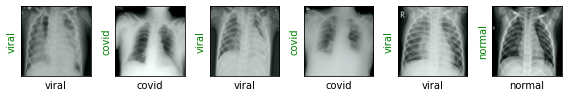

Conditia de performanta satisfacuta!


In [18]:
train(epochs=1)

# Rezultatele finale

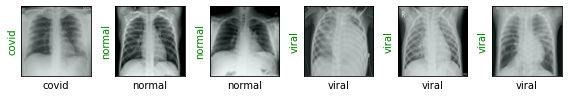

In [19]:
show_preds()

In principiu, ar trebui sa vedem ca se fac predictii corecte pentru un batch de 6 imagini, ceea ce este si cazul aici.